In [ ]:
# generated_drums = flattened_generated_drums

In [1]:
import numpy as np
import torch
import tqdm

quantized_analysis = False

model_folder = '[Larger srcMasked 30prcnt] [bassGuiSynLead] no in vel_itzc90b6'
model_name = '120.pth'
use_bernoulli = True
threshold = 0.5
groove_threshold = 0.6
predict_n_steps_at_a_time = 4


def load_data(get_flatten=False, ignore_first_n_bars=2, shift_frames_by=1, load_n_bars=8, steps_per_segment=1, prime_bars=0):
    full_path = f'{model_folder}/{model_name}/bern_{use_bernoulli}_prime_{prime_bars}_bars_thres_{threshold:.2f}_gthresh_{groove_threshold:.2f}_n_steps_per_gen_{predict_n_steps_at_a_time}'
    # load generations
    ignore_first_n_bars_ = max(2, ignore_first_n_bars)
    end_step = (load_n_bars+ignore_first_n_bars_)*16 // shift_frames_by
    generated_drums = torch.tensor(np.load(f'{full_path}/generated_drums.npy')[:, ignore_first_n_bars_*16:(load_n_bars+ignore_first_n_bars_)*16, :9])
    gt_drums = torch.tensor(np.load(f'{full_path}/drum_hvos_gt.npy')[:, ignore_first_n_bars_*16:(load_n_bars+ignore_first_n_bars_)*16, :9])
    if get_flatten:
        generated_drums = torch.clamp(generated_drums.sum(dim=-1), 0, 1).reshape(generated_drums.shape[0], -1, 1)
        gt_drums = torch.clamp(gt_drums.sum(dim=-1), 0, 1).reshape(gt_drums.shape[0], -1, 1)
        
    
    def jaccard(hvo_1, hvo_2):
        hvo_1 = hvo_1.reshape(hvo_1.shape[0], -1)
        hvo_2 = hvo_2.reshape(hvo_2.shape[0], -1)
        intersection = torch.sum(hvo_1 * hvo_2, dim=1)
        union = torch.sum(hvo_1 + hvo_2, dim=1)
        jac = intersection / (union - intersection)
        # replace nans with 0
        jac[torch.isnan(jac)] = 1
        return jac
    
    def cosine_similarity(hvo_1, hvo_2):
        hvo_1 = hvo_1.reshape(hvo_1.shape[0], -1)
        hvo_2 = hvo_2.reshape(hvo_2.shape[0], -1)
        return torch.sum(hvo_1 * hvo_2, dim=1) / (torch.norm(hvo_1, dim=1) * torch.norm(hvo_2, dim=1))
    
    def extract_segments(hvo_, n_bars_per_seg):
        n_bars = hvo_.shape[1] // 16
        n_segs = n_bars // n_bars_per_seg
        hvo_ = hvo_[:, :n_segs*n_bars_per_seg*16, :]
        hvo_ = hvo_.reshape(hvo_.shape[0], n_segs, n_bars_per_seg*16, hvo_.shape[2])
        return hvo_
        
    def compute_intra_jaccards(hvo_, n_bars_per_seg):
        hvo_segments = extract_segments(hvo_, n_bars_per_seg)
        N = hvo_segments.shape[1]
        intra_jaccards = torch.zeros(hvo_segments.shape[0], N*(N-1)//2)
        count = 0
        for i in range(0, N-1):
            for j in range(i+1, N):
                intra_jaccards[:, count] = jaccard(hvo_segments[:, i, :, :], hvo_segments[:, j, :, :])
                count += 1
        return intra_jaccards
    
    
    def compute_inter_jaccards(hvo_1, hvo_2, n_bars_per_seg):
        hvo_1_segments = extract_segments(hvo_1, n_bars_per_seg)
        hvo_2_segments = extract_segments(hvo_2, n_bars_per_seg)
        N = hvo_1_segments.shape[1]
        inter_jaccards = torch.zeros(hvo_1_segments.shape[0], N)
        
        for i in range(N):
            inter_jaccards[:, i] = jaccard(hvo_1_segments[:, i, :, :], hvo_2_segments[:, i, :, :])
            
        return inter_jaccards
    
    def quantize_jaccards(jaccards, n_bins=3):
        return torch.floor(jaccards * n_bins) / n_bins
    
    n_segments = 0
    for i in tqdm.trange(0, generated_drums.shape[1]-steps_per_segment-shift_frames_by, shift_frames_by):
        for j in range(0, generated_drums.shape[1]-steps_per_segment-shift_frames_by, shift_frames_by):
            n_segments += 1
        break
            
    
    print(n_segments)
    SSM_Generated = torch.zeros(generated_drums.shape[0], n_segments, n_segments)
    SSM_GT = torch.zeros(generated_drums.shape[0], n_segments, n_segments)
    CSM = torch.zeros(generated_drums.shape[0], n_segments, n_segments)
    
    ssm_i = 0
    for i in tqdm.trange(0, generated_drums.shape[1]-steps_per_segment-shift_frames_by, shift_frames_by):
        ssm_j = 0
        for j in range(0, generated_drums.shape[1]-steps_per_segment-shift_frames_by, shift_frames_by):
            if quantized_analysis:
                start_1 = i
                end_1 = i + steps_per_segment
                start_2 = j
                end_2 = j + steps_per_segment
                SSM_Generated[:, ssm_i,  ssm_j] = quantize_jaccards(jaccard(generated_drums[:, start_1:end_1, :], generated_drums[:, start_2:end_2, :]))
                SSM_GT[:, ssm_i,  ssm_j] = quantize_jaccards(jaccard(gt_drums[:, start_1:end_1, :], gt_drums[:, start_2:end_2, :]))
            else:
                start1 = i
                end1 = i + steps_per_segment
                start2 = j
                end2 = j + steps_per_segment
                SSM_Generated[:, ssm_i, ssm_j] = jaccard(generated_drums[:, start1:end1, :], generated_drums[:, start2:end2, :])
                SSM_GT[:, ssm_i, ssm_j] = jaccard(gt_drums[:, start1:end1, :], gt_drums[:, start2:end2, :])
            ssm_j += 1
        ssm_i += 1
    
    # cross similarity matrix (csm)
    ssm_i = 0
    for i in tqdm.trange(0, generated_drums.shape[1]-steps_per_segment-shift_frames_by, shift_frames_by):
        ssm_j = 0
        for j in range(0, generated_drums.shape[1]-steps_per_segment-shift_frames_by, shift_frames_by):
            if quantized_analysis:
                start_1 = i
                end_1 = i + steps_per_segment
                start_2 = j
                end_2 = j + steps_per_segment
                CSM[:, ssm_i,  ssm_j] = quantize_jaccards(jaccard(generated_drums[:, start_1:end_1, :], gt_drums[:, start_2:end_2, :]))
            else:
                start1 = i
                end1 = i + steps_per_segment
                start2 = j
                end2 = j + steps_per_segment
                CSM[:, ssm_i, ssm_j] = jaccard(generated_drums[:, start1:end1, :], gt_drums[:, start2:end2, :])
            ssm_j += 1
        ssm_i += 1
        
    return SSM_Generated, SSM_GT, CSM, generated_drums, gt_drums
    
    



In [2]:
torch.tensor([1, 2, 3])[2:10]

tensor([3])

In [3]:
# plot SSMs side by side
import random
from skimage.metrics import structural_similarity as ssim
steps_per_segment = 16
shift_frames_by = 16
get_flatten = False

SSM_Generated_2bars, SSM_GT, CSM_2bars, generated_drums, gt_drums = load_data(get_flatten=get_flatten, ignore_first_n_bars=2, shift_frames_by=shift_frames_by, load_n_bars=28, steps_per_segment=steps_per_segment, prime_bars=2)
SSM_Generated_0bars, SSM_GT_0bars, CSM_0bars, _, _ = load_data(get_flatten=get_flatten, ignore_first_n_bars=0, shift_frames_by=shift_frames_by, load_n_bars=28, steps_per_segment=steps_per_segment, prime_bars=0)

  0%|          | 0/26 [00:00<?, ?it/s]


26


  0%|          | 0/26 [00:00<?, ?it/s]


26


100%|██████████| 26/26 [00:00<00:00, 345.50it/s]


In [4]:
SSM_Generated_2bars.min()

tensor(0.)

No context
2Bar context


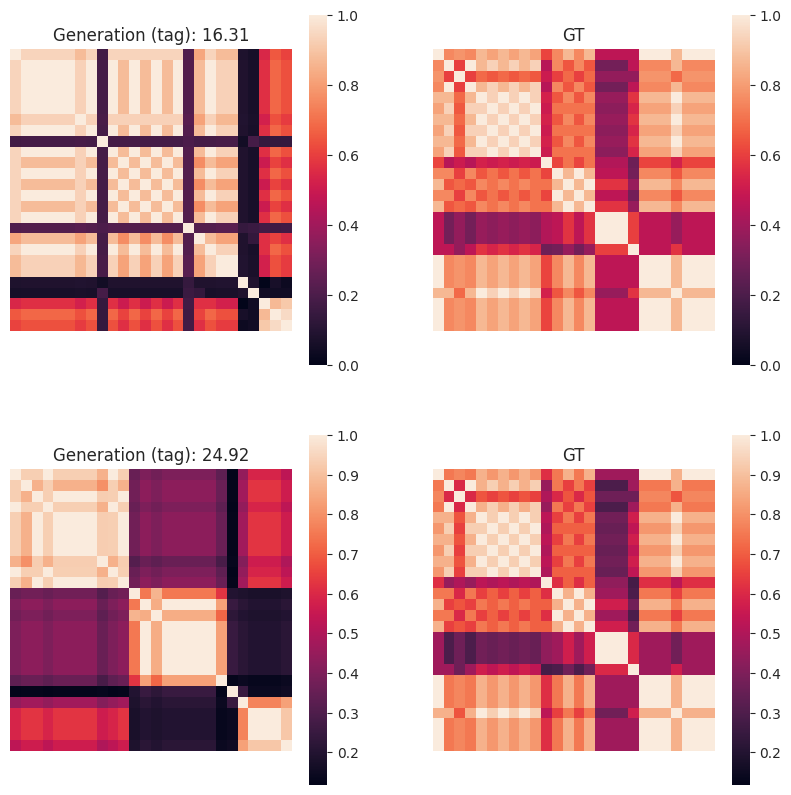

In [5]:

sample_ix = random.randint(0, SSM_Generated_2bars.shape[0])
sample_ix = 1456

SSM_gen_no_context = SSM_Generated_0bars[sample_ix].detach().numpy()
SSM_gt_no_context = SSM_GT_0bars[sample_ix].detach().numpy()

SSM_gen_with_context = SSM_Generated_2bars[sample_ix].detach().numpy()
SSM_gt_with_context = SSM_GT[sample_ix].detach().numpy()


import matplotlib.pyplot as plt
import seaborn as sns

# create 3 separate figures
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# use same heat map scale for both
for i, (tag, SSM_gen, SSM_gt) in enumerate([("No context", SSM_gen_no_context, SSM_gt_no_context), ("2Bar context", SSM_gen_with_context, SSM_gt_with_context)]):
    ax1 = axs[i]
    print(tag)
    max_val = max(np.max(SSM_gen), np.max(SSM_gt))
    min_val = min(np.min(SSM_gen), np.min(SSM_gt))
    
    def generate_upper_matrix(matrix):
        return torch.nn.Transformer.generate_square_subsequent_mask(matrix.shape[1]).bool().numpy()

    indices_to_check = generate_upper_matrix(SSM_gen)
    percent_match = np.sum(np.abs(SSM_gen[indices_to_check]-SSM_gt[indices_to_check]) < 0.1) / indices_to_check.sum()
    
    title = f'Gener\nPercent Matching: {indices_to_check}'
    
    # Create a discrete colormap with 4 colors
    from matplotlib.colors import ListedColormap
    
    # use shades of grey
    if quantized_analysis:
        colors = ['#ffcc00', '#ff6600', '#cc0000', '#660066']
        
        cmap = ListedColormap(colors)
    
        sns.heatmap(SSM_gen, ax=ax1[0], vmin=0, vmax=1, cbar=False, cmap = cmap)
        sns.heatmap(SSM_gt, ax=ax1[1], vmin=0, vmax=1, cbar=False, cmap = cmap)
    else:
        sns.heatmap(SSM_gen, ax=ax1[0], vmin=min_val, vmax=max_val, cbar=True)
        sns.heatmap(SSM_gt, ax=ax1[1], vmin=min_val, vmax=max_val, cbar=True)
        
    # show standard deviation for each column
    
    
    
    # show sums
    
    # equal aspect ratio
    for ax_ in ax1:
        ax_.set_aspect('equal')
        
    # Add the custom color bar labels
    cbar = ax1[1].collections[0].colorbar
    
    # colorbar only for the second plot
    
    # remove x and y labels, ticks
    
    for ix, ax_ in enumerate(ax1):
        ax_.aspect = 'equal'
        ax_.set_xticks(list(range(0, SSM_gen.shape[0], 4)))
        ax_.set_yticks(list(range(0, SSM_gen.shape[0], 4)))
        # ax_.set_xlabel('Bar Count')
        # ax_.set_ylabel('Bar Count')
        ax_.set_title('GT' if ix % 3 == 1 else f'Generation (tag): {percent_match*100:.2f}')
        cbar = ax_.collections[0].colorbar
        if cbar is not None and quantized_analysis:
            cbar.set_ticks([0.125, 0.375, 0.625, 0.875])  # Midpoints of the four colors
            cbar.set_ticklabels(['No Similarity', 'Little Similarity', 'Some Similarity', 'Very Similar'])
    
    
            
    
    # colorbar range (0, 1)
    # color bar ticks (0, 0.25, 0.5, 0.75, 1)
    
    # color bar labels (0, 0.25, 0.5, 0.75, 1)
    
    
    # calculate dot product of the two matrices, normalized by the product of their norms
    # this is the cosine similarity
    

# calculate ssim
plt.savefig('Inter: 0.81, IraGt: 0.71, IraGen: 0.88.png', dpi=300)

325 (26, 26)


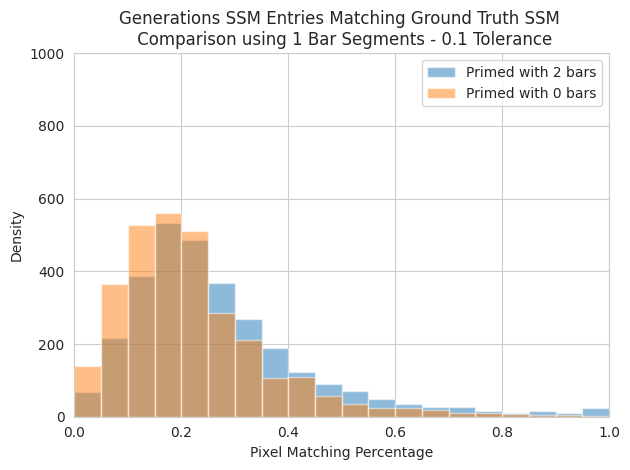

[[False  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True]
 [False False  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True]
 [False False False  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True]
 [False False False False  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True]
 [False False False False False  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True]
 [False False False False False False  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True]
 [False False False Fa

In [6]:
# get all ssim values
SSM_Generated_2bars = SSM_Generated_2bars
SSM_GT_2bars = SSM_GT
SSM_Generated_0bars = SSM_Generated_0bars
SSM_GT_0bars = SSM_GT_0bars

percent_matching_2bars = np.zeros(SSM_Generated_2bars.shape[0])
percent_matching_0bars = np.zeros(SSM_Generated_0bars.shape[0])

import cv2
import numpy as np


def generate_upper_matrix(matrix):
    return torch.nn.Transformer.generate_square_subsequent_mask(matrix.shape[1]).bool().numpy()
    
indices_to_check2bar = generate_upper_matrix(SSM_Generated_2bars[0])
indices_to_check0bar = generate_upper_matrix(SSM_Generated_0bars[0])
print(indices_to_check2bar.sum(), indices_to_check2bar.shape)
for i in range(SSM_Generated_2bars.shape[0]):
    percent_matching_2bars[i] = torch.sum((torch.abs(SSM_Generated_2bars[i][indices_to_check2bar] - SSM_GT_2bars[i][indices_to_check2bar]) < 0.1)) / indices_to_check2bar.sum()
    # percent_matching_2bars[i] = check_pixel_matching_upper_triangular(SSM_Generated_2bars[i].detach().numpy())
    
for i in range(SSM_Generated_0bars.shape[0]):
    percent_matching_0bars[i] = torch.sum((torch.abs(SSM_Generated_0bars[i][indices_to_check0bar] - SSM_GT_0bars[i][indices_to_check0bar]) < 0.1)) / indices_to_check0bar.sum()
    
# show histogram of ssim values
# kdensity plot

# # show normalized histograms as well
plt.hist(percent_matching_2bars, bins=20, alpha=0.5, density=False, label='Primed with 2 bars')
plt.hist(percent_matching_0bars, bins=20, alpha=0.5, density=False, label='Primed with 0 bars')

# fit a gaussian to the data
from scipy.stats import norm
import matplotlib.mlab as mlab
plt.xlim(0, 1)
plt.ylim(0, 1000)

plt.xlabel('Pixel Matching Percentage')
plt.ylabel('Density')
plt.title(f'Generations SSM Entries Matching Ground Truth SSM \n Comparison using {steps_per_segment//16} Bar Segments - 0.1 Tolerance', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig(f'ssm_matching_{steps_per_segment//16}Bars.png', dpi=300)

plt.show()

print(indices_to_check0bar)

In [7]:
def jaccard(hvo_1, hvo_2):
    hvo_1 = hvo_1.reshape(hvo_1.shape[0], -1)
    hvo_2 = hvo_2.reshape(hvo_2.shape[0], -1)
    intersection = torch.sum(hvo_1 * hvo_2, dim=1)
    union = torch.sum(hvo_1 + hvo_2, dim=1)
    jac = intersection / (union - intersection)
    jac[torch.isnan(jac)] = 0
    return jac

def extract_segments(hvo_, n_bars_per_seg):
    n_bars = hvo_.shape[1] // 16
    n_segs = n_bars // n_bars_per_seg
    hvo_ = hvo_[:, :n_segs*n_bars_per_seg*16, :]
    hvo_ = hvo_.reshape(hvo_.shape[0], n_segs, n_bars_per_seg*16, hvo_.shape[2])
    return hvo_
    
def compute_intra_jaccards(hvo_, n_bars_per_seg):
    hvo_segments = extract_segments(hvo_, n_bars_per_seg)
    N = hvo_segments.shape[1]
    intra_jaccards = torch.zeros(hvo_segments.shape[0], N*(N-1)//2)
    count = 0
    for i in range(0, N-1):
        for j in range(i+1, N):
            intra_jaccards[:, count] = jaccard(hvo_segments[:, i, :, :], hvo_segments[:, j, :, :])
            count += 1
    return intra_jaccards


def compute_inter_jaccards(hvo_1, hvo_2, n_bars_per_seg):
    hvo_1_segments = extract_segments(hvo_1, n_bars_per_seg)
    hvo_2_segments = extract_segments(hvo_2, n_bars_per_seg)
    N = hvo_1_segments.shape[1]
    inter_jaccards = torch.zeros(hvo_1_segments.shape[0], N)
    
    for i in range(N):
        inter_jaccards[:, i] = jaccard(hvo_1_segments[:, i, :, :], hvo_2_segments[:, i, :, :])
        
    return inter_jaccards

intra_generation_jaccards = compute_intra_jaccards(generated_drums, 1)
intra_gt_jaccards = compute_intra_jaccards(gt_drums, 1)

# get box_plot data for each example
intra_gen_average = torch.mean(intra_generation_jaccards, dim=1)
intra_gt_average = torch.mean(intra_gt_jaccards, dim=1)
inter_jaccards = compute_inter_jaccards(generated_drums, gt_drums, 1).mean(dim=1)
sorted_inter_jaccards, indices = torch.sort(inter_jaccards)
sorted_intra_gt = intra_gt_average[indices]

fi = -3000
sorted_inter_jaccards[fi], sorted_intra_gt[fi], indices[fi]
fname = (f'Inter: {sorted_inter_jaccards[fi]:0.2f}, IraGt: {sorted_intra_gt[fi]:0.2f}, IraGen: {intra_gen_average[indices[fi]]:0.2f}, Index: {indices[fi]}, fi: {fi}')
fname

'Inter: 0.01, IraGt: 0.49, IraGen: 0.31, Index: 168, fi: -3000'

/tmp/ipykernel_83273/2790601440.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.87, 1])  # Adjust layout to make room for the colorbar


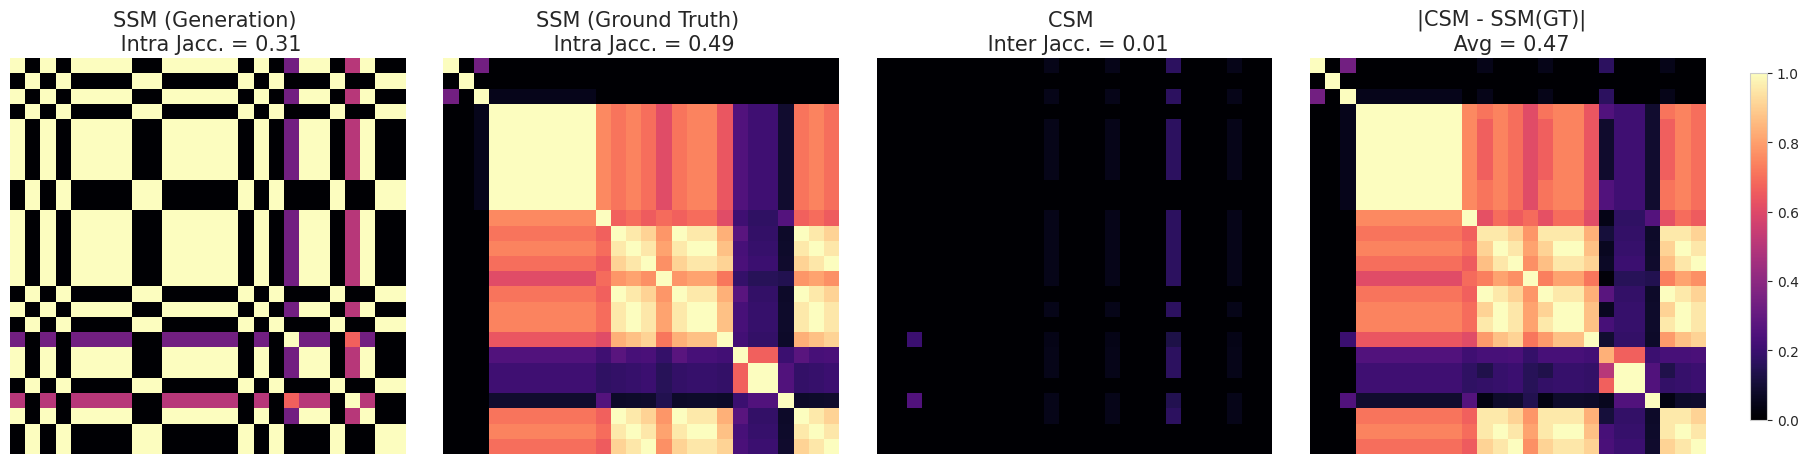

In [11]:


sample_ix = indices[fi]

SSM_gen_no_context = SSM_Generated_0bars[sample_ix].detach().numpy()
SSM_gt_no_context = SSM_GT_0bars[sample_ix].detach().numpy()

SSM_gen_with_context = SSM_Generated_2bars[sample_ix].detach().numpy()
SSM_gt_with_context = SSM_GT[sample_ix].detach().numpy()

CSM = CSM_2bars[sample_ix].detach().numpy()

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming quantized_analysis and other required variables are defined
# Create the figure and subplots
# Assuming quantized_analysis and other required variables are defined
# Create the figure and subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 4.5))

# Use the same heatmap scale for both SSM_gen and SSM_gt
if quantized_analysis:
    colors = ['#ffcc00', '#ff6600', '#cc0000', '#660066']
    cmap = ListedColormap(colors)
else:
    cmap = 'magma'

# Generate heatmaps without colorbars
sns.heatmap(SSM_gen_with_context, ax=axs[0], vmin=0, vmax=1, cbar=False, cmap=cmap)
sns.heatmap(SSM_gt_with_context, ax=axs[1], vmin=0, vmax=1, cbar=False, cmap=cmap)
sns.heatmap(CSM, ax=axs[2], vmin=0, vmax=1, cbar=False, cmap=cmap)

# Calculate absolute difference
abs_diff = np.abs(SSM_gt_with_context - CSM)
abs_diff_avg = np.mean(abs_diff[indices_to_check])

# Plot the absolute difference
sns.heatmap(abs_diff, ax=axs[3], vmin=0, vmax=1, cbar=False, cmap=cmap)

# Set aspect ratio and labels
for ix, ax_ in enumerate(axs):
    ax_.set_aspect('equal')
    ax_.set_xticks(list(range(0, SSM_gen_with_context.shape[0], 4)))
    ax_.set_yticks(list(range(0, SSM_gen_with_context.shape[0], 4)))

    if ix == 0:
        ax_.set_title(f'SSM (Generation) \n Intra Jacc. = {intra_gen_average[indices[fi]]:0.2f}', fontsize=15)
    elif ix == 1:
        ax_.set_title(f'SSM (Ground Truth) \n Intra Jacc. = {intra_gt_average[indices[fi]]:0.2f}', fontsize=15)
    elif ix == 2:
        ax_.set_title(f'CSM \n Inter Jacc. = {sorted_inter_jaccards[fi]:0.2f}', fontsize=15)
    elif ix == 3:
        ax_.set_title(f'|CSM - SSM(GT)|  \n Avg = {abs_diff_avg:0.2f}', fontsize=15)
        
# Add a single colorbar to the right of the plots
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.1)
if quantized_analysis:
    cbar.set_ticks([0.125, 0.375, 0.625, 0.875])
    cbar.set_ticklabels(['No Similarity', 'Little Similarity', 'Some Similarity', 'Very Similar'])

plt.tight_layout(rect=[0, 0, 0.87, 1])  # Adjust layout to make room for the colorbar

# calculate ssim
plt.savefig(f'plots/{fname}.png', dpi=300, bbox_inches='tight')

plt.show()

/tmp/ipykernel_83273/4245055881.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.87, 1])  # Adjust layout to make room for the colorbar


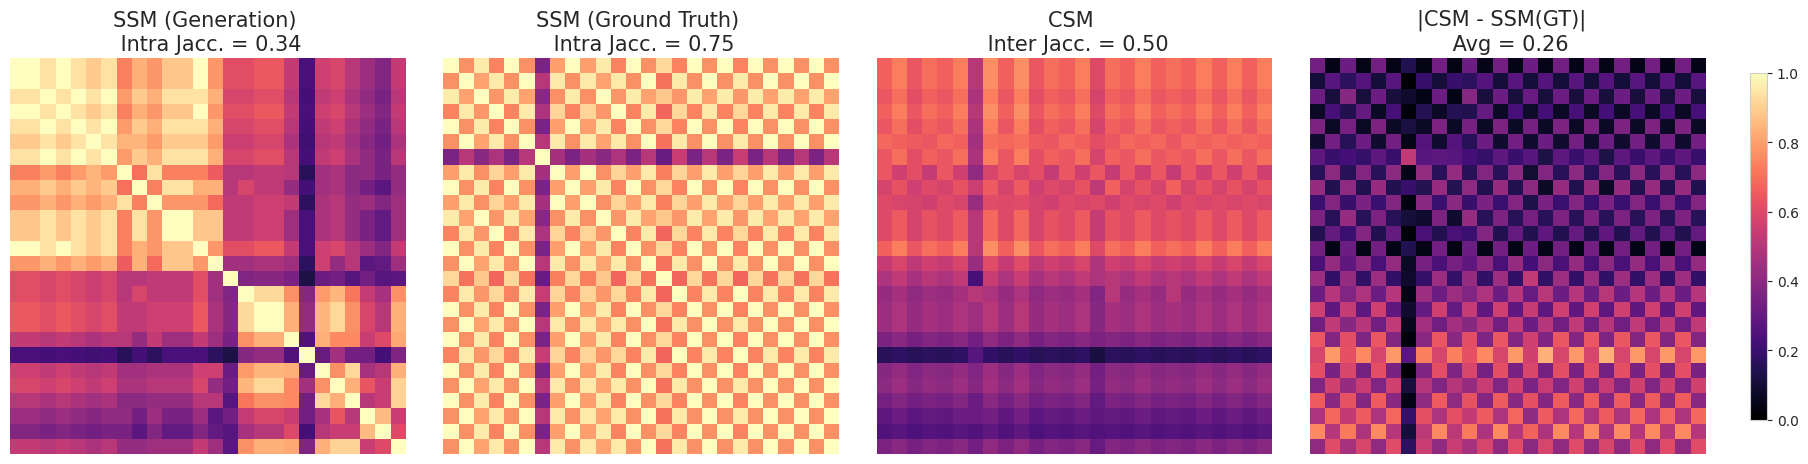

In [41]:


sample_ix = np.random.randint(0, SSM_Generated_2bars.shape[0])

SSM_gen_no_context = SSM_Generated_0bars[sample_ix].detach().numpy()
SSM_gt_no_context = SSM_GT_0bars[sample_ix].detach().numpy()

SSM_gen_with_context = SSM_Generated_2bars[sample_ix].detach().numpy()
SSM_gt_with_context = SSM_GT[sample_ix].detach().numpy()

CSM = CSM_2bars[sample_ix].detach().numpy()

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming quantized_analysis and other required variables are defined
# Create the figure and subplots
# Assuming quantized_analysis and other required variables are defined
# Create the figure and subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 4.5))

# Use the same heatmap scale for both SSM_gen and SSM_gt
if quantized_analysis:
    colors = ['#ffcc00', '#ff6600', '#cc0000', '#660066']
    cmap = ListedColormap(colors)
else:
    cmap = 'magma'

# Generate heatmaps without colorbars
sns.heatmap(SSM_gen_with_context, ax=axs[0], vmin=0, vmax=1, cbar=False, cmap=cmap)
sns.heatmap(SSM_gt_with_context, ax=axs[1], vmin=0, vmax=1, cbar=False, cmap=cmap)
sns.heatmap(CSM, ax=axs[2], vmin=0, vmax=1, cbar=False, cmap=cmap)

# Calculate absolute difference
abs_diff = np.abs(SSM_gt_with_context - CSM)
abs_diff_avg = np.mean(abs_diff[indices_to_check])

# Plot the absolute difference
sns.heatmap(abs_diff, ax=axs[3], vmin=0, vmax=1, cbar=False, cmap=cmap)

# Set aspect ratio and labels
for ix, ax_ in enumerate(axs):
    ax_.set_aspect('equal')
    ax_.set_xticks(list(range(0, SSM_gen_with_context.shape[0], 4)))
    ax_.set_yticks(list(range(0, SSM_gen_with_context.shape[0], 4)))

    if ix == 0:
        ax_.set_title(f'SSM (Generation) \n Intra Jacc. = {intra_gen_average[indices[sample_ix]]:0.2f}', fontsize=15)
    elif ix == 1:
        ax_.set_title(f'SSM (Ground Truth) \n Intra Jacc. = {intra_gt_average[indices[sample_ix]]:0.2f}', fontsize=15)
    elif ix == 2:
        ax_.set_title(f'CSM \n Inter Jacc. = {inter_jaccards[sample_ix]:0.2f}', fontsize=15)
    elif ix == 3:
        ax_.set_title(f'|CSM - SSM(GT)|  \n Avg = {abs_diff_avg:0.2f}', fontsize=15)
        
# Add a single colorbar to the right of the plots
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.1)
if quantized_analysis:
    cbar.set_ticks([0.125, 0.375, 0.625, 0.875])
    cbar.set_ticklabels(['No Similarity', 'Little Similarity', 'Some Similarity', 'Very Similar'])

plt.tight_layout(rect=[0, 0, 0.87, 1])  # Adjust layout to make room for the colorbar

# calculate ssim
plt.savefig(f'plots/{fname}.png', dpi=300, bbox_inches='tight')

plt.show()